# k-means Clustering

## Table of contents

[1.) Simple k-means clustering example](#section_1)<br>
[2.) Image segmentation](#section_2)<br>
[3.) 3D point cloud segmentation](#section_3)<br>
[4.) Finding clusters in the apartment data](#section_4)

## Libraries and settings

In [479]:
# Libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Current working directory
print('\nCurrent working directory:', os.getcwd())


Current working directory: /Users/sauternicolas/git/data_analytics/Week_10


## 1.) Simple k-means clustering example
<a id='section_1'></a>

### Create the dataset

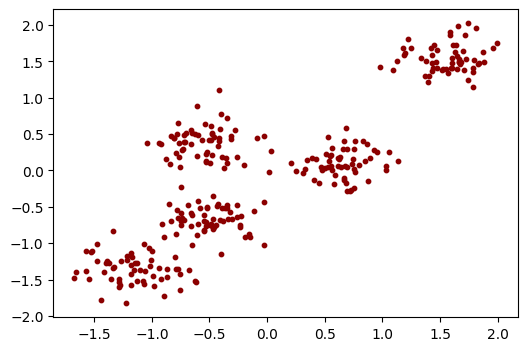

In [480]:
# Create data
centers = [[2,1], [-2,2], [-2,-2], [-4,-5], [5,7]]
X, y = make_blobs(n_samples=300, 
                  centers=centers, 
                  cluster_std=0.8,
                  random_state=42)

# Normalization of the values
X = StandardScaler().fit_transform(X)

# Plot the data
plt.figure(figsize=(6,4))
plt.scatter(X[:,0], X[:,1], s=10, color='darkred')
plt.show()

### Elbow Method showing the optimal k

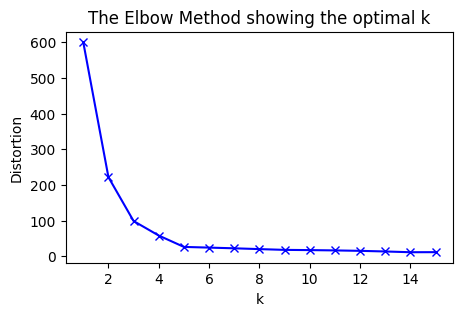

In [481]:
# Sum of squared distances of samples to their closest cluster center
distortions = []

# Range of k's
K = range(1,16,1)

# Loop to find the optimal k
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
   
# Elbow plot
plt.figure(figsize=(5,3))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### Task 1 a)
k = 3

### Perform k-means clustering

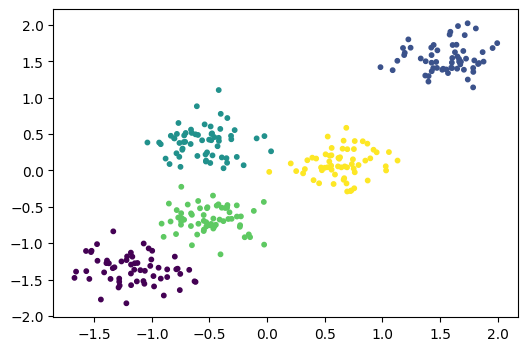

In [482]:
# Number of clusters
k = 5

# k-means clustering
kmeans = KMeans(n_clusters=k, random_state=42).fit(X)

# Predict the values
y2 = kmeans.predict(X)

# Plot the clusters
plt.figure(figsize=(6,4))
plt.scatter(X[:, 0], X[:, 1], c=y2, s=10)
plt.show()

### Get and check the converged cluster centroids

In [483]:
# Print centroids
centroids = kmeans.cluster_centers_
print('Cluster centroids:')
print(centroids, '\n')

# Check the 1st cluster's centroid 'by hand'
clust_00 = X[y2 == 0]
print('The 1st cluster\'s centroid:')
print(f'x = {sum(clust_00[:,0]/len(clust_00[:,0])):.8f}')
print(f'y = {sum(clust_00[:,1]/len(clust_00[:,1])):.8f}')

Cluster centroids:
[[-1.16214999 -1.36217282]
 [ 1.56276666  1.54186443]
 [-0.55467879  0.3889481 ]
 [-0.49867406 -0.67040574]
 [ 0.64167824  0.09023659]] 

The 1st cluster's centroid:
x = -1.16214999
y = -1.36217282


### Get the inertia or 'within-cluster sum-of-squares (WCSS)' of the k-means model

In [484]:
print(f'Within-cluster sum-of-squares: {kmeans.inertia_:.4f}')

Within-cluster sum-of-squares: 26.3487


### Perform Silhouette Analysis
- For examples see:
- https://laid-back-scientist.com/en/k-means
- https://machinelearninggeek.com/evaluating-clustering-methods
- https://medium.com/@favourphilic/how-to-interpret-silhouette-plot-for-k-means-clustering-414e144a17fe

k=2, Silhouette Score: 0.5325


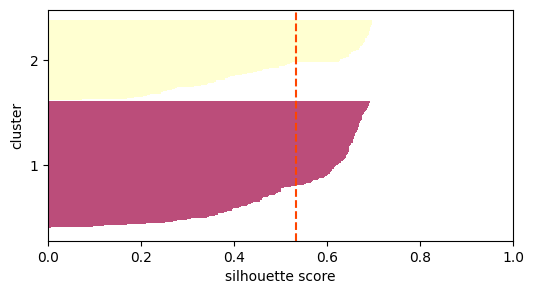

k=3, Silhouette Score: 0.5659


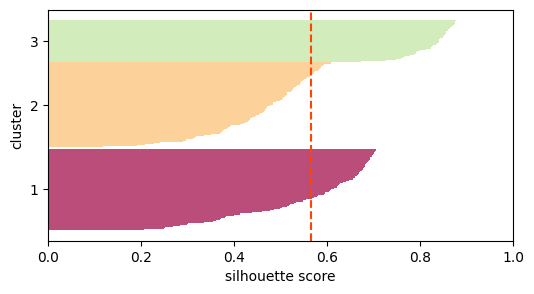

k=4, Silhouette Score: 0.6257


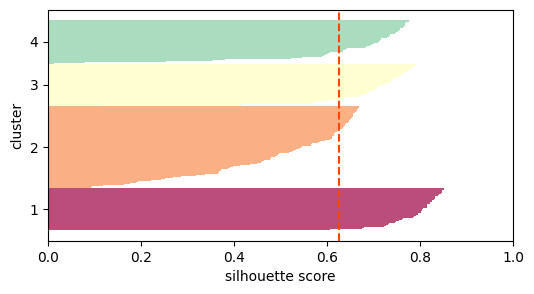

k=5, Silhouette Score: 0.6597


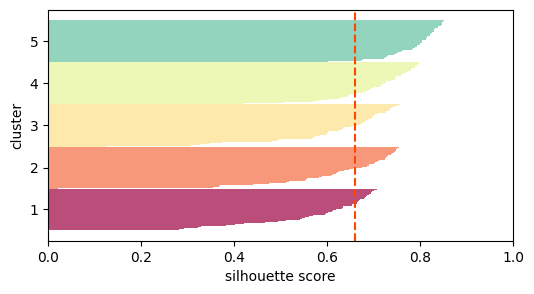

k=6, Silhouette Score: 0.6110


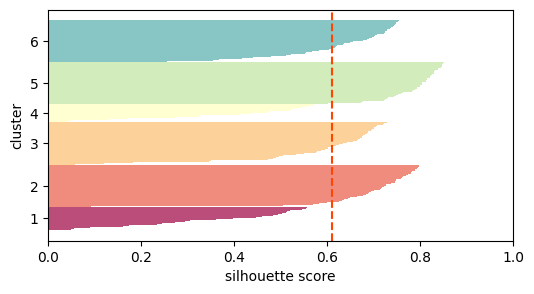

k=7, Silhouette Score: 0.5223


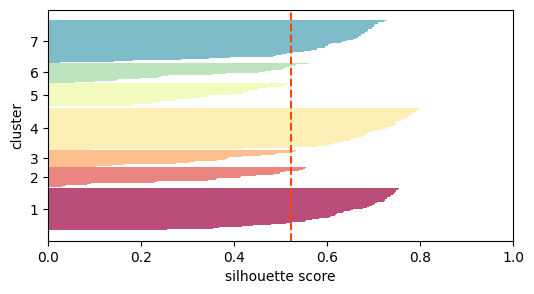

k=8, Silhouette Score: 0.4926


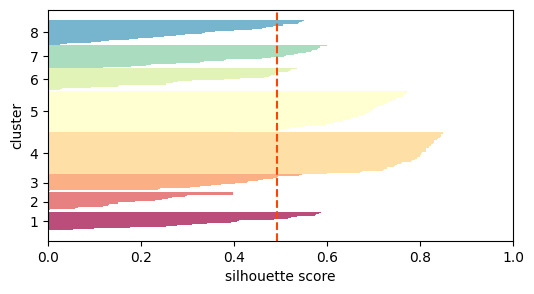

k=9, Silhouette Score: 0.4076


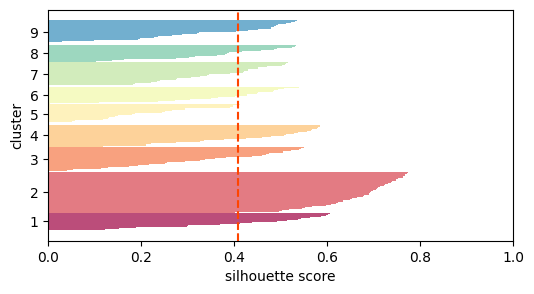

k=10, Silhouette Score: 0.4020


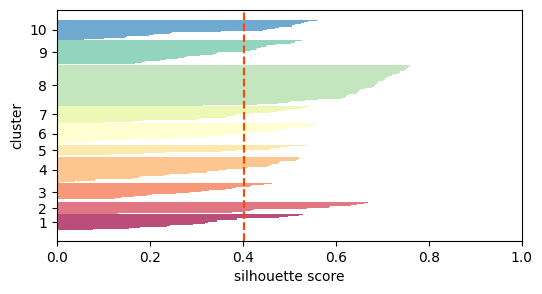

k=11, Silhouette Score: 0.3349


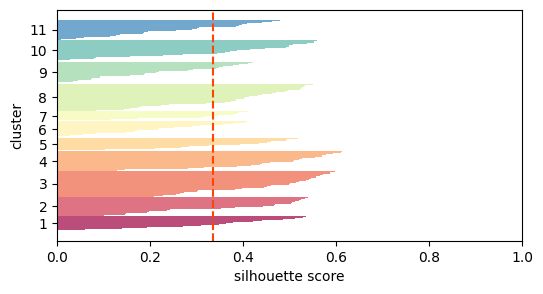

In [485]:
# Import own module for Silhouette plots
from silhouette import *

# Create Silhouette plots for different k's
# Note: range(2,12,1) provides: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
for i in range(2,12,1):
    model = KMeans(n_clusters=i, 
                   random_state=42, 
                   init='random')
    model.fit(X)
    print(f'k={i}, Silhouette Score: {silhouette_score(X, model.labels_):.4f}')
    plt.figure(figsize=(6,3))
    show_silhouette(X=X, fitted_model=model)

## 2.) Image segmentation
<a id='section_2'></a>

### Read the image

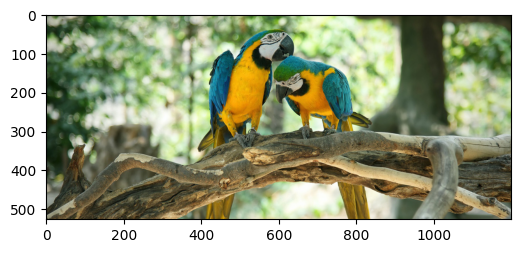

In [486]:
# Read the image
image = cv2.imread('parrot.jpg')
 
# Change the color to RGB (from BGR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image
plt.figure(figsize=(6,8))
plt.imshow(image)

### Reshape the image

In [487]:
# Reshaping the image into a 2D array of pixels and RGB colors
pixel_vals = image.reshape((-1,3))
 
# Convert to float
pixel_vals = np.float32(pixel_vals)
pixel_vals

array([[ 37.,  68.,  37.],
       [ 37.,  70.,  39.],
       [ 43.,  76.,  45.],
       ...,
       [102., 112., 113.],
       [102., 114., 114.],
       [102., 114., 114.]], dtype=float32)

### Elbow method showing the optimal k

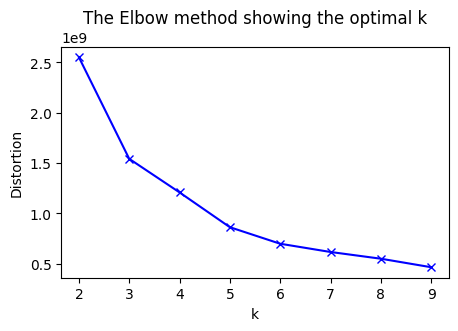

In [488]:
# Sum of squared distances of samples to their closest cluster center
distortions = []

# Range of k's
K = range(2,10,1)

# Loop to find the optimal k
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(pixel_vals)
    distortions.append(kmeanModel.inertia_)
    
# Elbow plot
plt.figure(figsize=(5,3))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow method showing the optimal k')

plt.show()

### Perform image segmentation

In [489]:
# Number of clusters
k = 5

# Criteria for the segmentation algorithm to stop running
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
 
# Perform k-means clustering
retval, labels, centers = cv2.kmeans(pixel_vals, 
                                     k, 
                                     None, 
                                     criteria, 
                                     10, 
                                     cv2.KMEANS_RANDOM_CENTERS)

# Print cluster labels
print('Cluster labels:')
print(labels, '\n')

# Print cluster centroids
print(f'Centroids of {k} clusters')
print(centers)

Cluster labels:
[[2]
 [2]
 [2]
 ...
 [4]
 [4]
 [4]] 

Centroids of 5 clusters
[[217.86786  229.67361  192.82979 ]
 [162.50127  177.15588  132.24716 ]
 [ 54.80433   64.238045  41.408085]
 [206.78395  142.92953   10.190424]
 [106.72457  114.88698   79.77704 ]]


### Change data types and reshape the segmented data for visualization

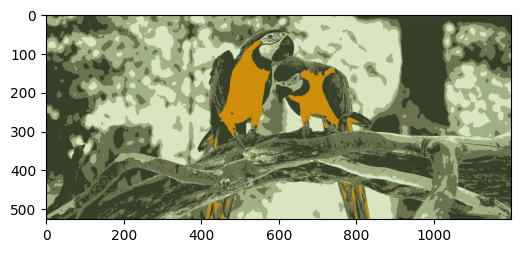

In [490]:
# Convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
 
# Reshape data into the original image dimensions
segmented_image = segmented_data.reshape((image.shape))

# Show result
plt.figure(figsize=(6,8))
plt.imshow(segmented_image)

## 2.) Image segmentation Exercices 

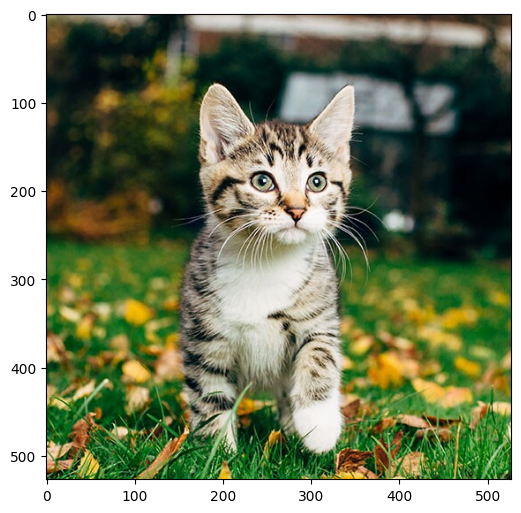

In [491]:
# Read the image
image = cv2.imread('katze.jpg')
 
# Change the color to RGB (from BGR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image
plt.figure(figsize=(6,8))
plt.imshow(image)

In [492]:
# Reshaping the image into a 2D array of pixels and RGB colors
pixel_vals = image.reshape((-1,3))
 
# Convert to float
pixel_vals = np.float32(pixel_vals)
pixel_vals

array([[152., 144., 107.],
       [153., 145., 108.],
       [155., 147., 110.],
       ...,
       [ 25.,  46.,  31.],
       [  7.,  41.,  17.],
       [  4.,  46.,  10.]], dtype=float32)

### Elbow method showing the optimal k

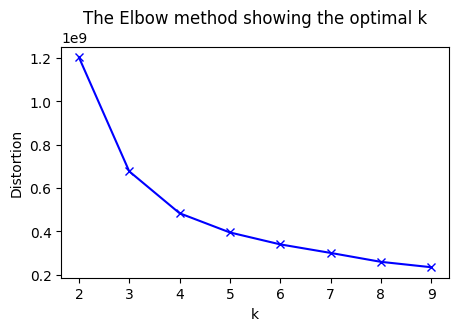

In [493]:
# Sum of squared distances of samples to their closest cluster center
distortions = []

# Range of k's
K = range(2,10,1)

# Loop to find the optimal k
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(pixel_vals)
    distortions.append(kmeanModel.inertia_)
    
# Elbow plot
plt.figure(figsize=(5,3))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow method showing the optimal k')

plt.show()

### K=2

Cluster labels:
[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]] 

Centroids of 2 clusters
[[ 48.53262   68.748085  31.818546]
 [186.55801  177.16844  142.51811 ]]


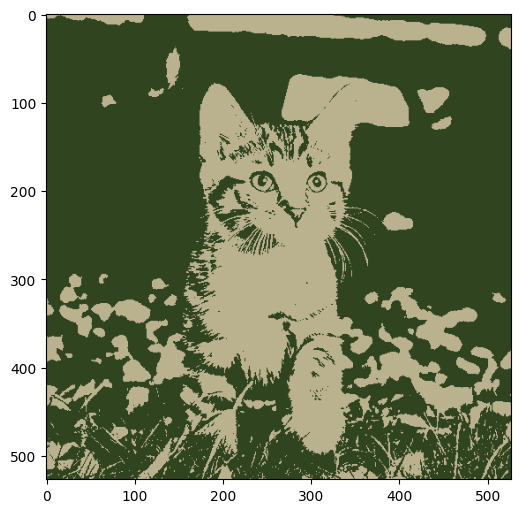

In [494]:
# Number of clusters
k = 2

# Criteria for the segmentation algorithm to stop running
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
 
# Perform k-means clustering
retval, labels, centers = cv2.kmeans(pixel_vals, 
                                     k, 
                                     None, 
                                     criteria, 
                                     10, 
                                     cv2.KMEANS_RANDOM_CENTERS)

# Print cluster labels
print('Cluster labels:')
print(labels, '\n')

# Print cluster centroids
print(f'Centroids of {k} clusters')
print(centers)

# Convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
 
# Reshape data into the original image dimensions
segmented_image = segmented_data.reshape((image.shape))

# Show result
plt.figure(figsize=(6,8))
plt.imshow(segmented_image)

### K=4

Cluster labels:
[[1]
 [1]
 [1]
 ...
 [3]
 [3]
 [3]] 

Centroids of 4 clusters
[[ 80.63064   98.013626  41.029877]
 [157.94936  146.31226   92.11941 ]
 [211.09924  204.3231   187.63087 ]
 [ 15.859981  40.34215   22.189833]]


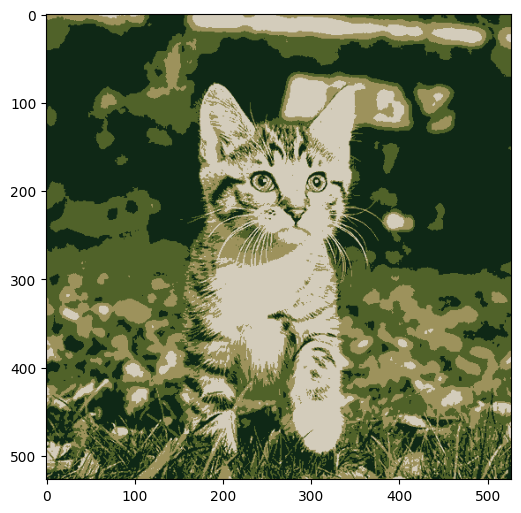

In [495]:
# Number of clusters
k = 4

# Criteria for the segmentation algorithm to stop running
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
 
# Perform k-means clustering
retval, labels, centers = cv2.kmeans(pixel_vals, 
                                     k, 
                                     None, 
                                     criteria, 
                                     10, 
                                     cv2.KMEANS_RANDOM_CENTERS)

# Print cluster labels
print('Cluster labels:')
print(labels, '\n')

# Print cluster centroids
print(f'Centroids of {k} clusters')
print(centers)

# Convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
 
# Reshape data into the original image dimensions
segmented_image = segmented_data.reshape((image.shape))

# Show result
plt.figure(figsize=(6,8))
plt.imshow(segmented_image)

### K=6

Cluster labels:
[[2]
 [2]
 [2]
 ...
 [1]
 [1]
 [1]] 

Centroids of 6 clusters
[[ 53.240555  83.78688   32.5922  ]
 [ 11.360692  31.918564  20.69385 ]
 [161.02385  158.4601   136.73824 ]
 [110.1797   114.364685  55.989788]
 [218.81943  211.99164  197.1739  ]
 [192.99814  158.45444   63.274883]]


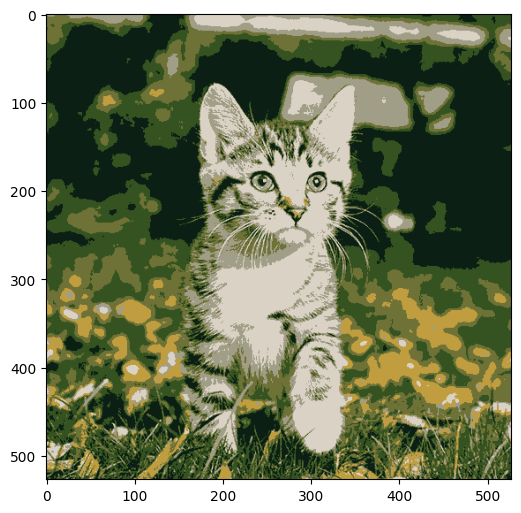

In [496]:
# Number of clusters
k = 6

# Criteria for the segmentation algorithm to stop running
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
 
# Perform k-means clustering
retval, labels, centers = cv2.kmeans(pixel_vals, 
                                     k, 
                                     None, 
                                     criteria, 
                                     10, 
                                     cv2.KMEANS_RANDOM_CENTERS)

# Print cluster labels
print('Cluster labels:')
print(labels, '\n')

# Print cluster centroids
print(f'Centroids of {k} clusters')
print(centers)

# Convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
 
# Reshape data into the original image dimensions
segmented_image = segmented_data.reshape((image.shape))

# Show result
plt.figure(figsize=(6,8))
plt.imshow(segmented_image)

### K=12

Cluster labels:
[[ 2]
 [ 2]
 [ 2]
 ...
 [11]
 [ 8]
 [ 8]] 

Centroids of 12 clusters
[[217.00867  180.50153  101.783035]
 [178.17921  146.26689   46.586117]
 [150.11226  149.14561  125.05583 ]
 [228.15393  222.25142  211.53365 ]
 [ 77.57945   69.40233   35.516827]
 [190.5116   186.30235  169.17863 ]
 [ 18.811678  92.51695   22.914688]
 [ 66.72121  115.46683   38.795784]
 [  5.303234  23.155842  18.242092]
 [108.917274 114.45781   85.29937 ]
 [122.57153  115.19858   35.294395]
 [ 31.917208  48.55239   29.95491 ]]


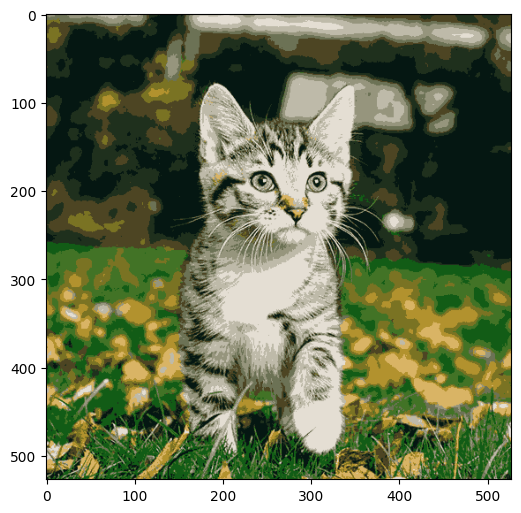

In [497]:
# Number of clusters
k = 12

# Criteria for the segmentation algorithm to stop running
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
 
# Perform k-means clustering
retval, labels, centers = cv2.kmeans(pixel_vals, 
                                     k, 
                                     None, 
                                     criteria, 
                                     10, 
                                     cv2.KMEANS_RANDOM_CENTERS)

# Print cluster labels
print('Cluster labels:')
print(labels, '\n')

# Print cluster centroids
print(f'Centroids of {k} clusters')
print(centers)

# Convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
 
# Reshape data into the original image dimensions
segmented_image = segmented_data.reshape((image.shape))

# Show result
plt.figure(figsize=(6,8))
plt.imshow(segmented_image)

## 3.) 3D point cloud segmentation
- For details see: https://towardsdatascience.com/3d-point-cloud-clustering-tutorial-with-k-means-and-python-c870089f3af8
- Data-Viewer: https://app.flyvast.com/flyvast/app/page-snapshot-viewer.html#/444/9b557b91-8f41-16fa-cd2d-3476a1756611
<a id='section_3'></a>

### Import the data (Airport LIDAR point cloud dataset)

In [498]:
# Import the data
data = "KME_planes.xyz"
x, y, z, illuminance, reflectance, intensity, nb_of_returns = np.loadtxt(data,
                                                                         skiprows=1, 
                                                                         delimiter=';', 
                                                                         unpack=True)
# Array with positions of points
pcd = np.column_stack((x,y,z))

# Mean of z-variable (height above ground)
print(np.mean(z).round(4))

# Subset of the point cloud 
mask = (z > np.mean(z)) & (x <= 320) & (x >= 230)
spatial_query = pcd[mask]
spatial_query.shape

5.2829


(9676, 3)

### 3D plot of the point cloud subset

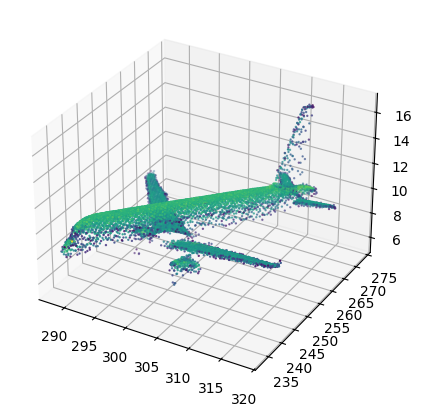

In [499]:
# 3D plot of the subset
plt.figure(figsize=(5,5))
ax = plt.axes(projection ='3d')
ax.scatter(x[mask], y[mask], z[mask], c=intensity[mask], s=0.5)
plt.show()

### 2D plot of the point cloud subset

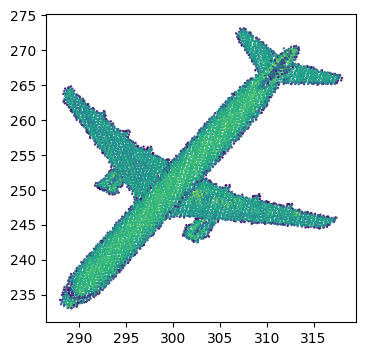

In [500]:
# 2D plot of the subset
plt.figure(figsize=(4,4))
plt.scatter(x[mask], y[mask], c=intensity[mask], s=0.5)
plt.show()

### Elbow method showing the optimal k

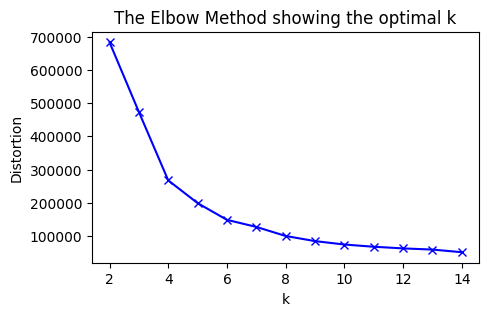

In [501]:
# Sum of squared distances of samples to their closest cluster center
distortions = []

# Range of k's
K = range(2,15,1)

# Loop to find the optimal k
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(spatial_query)
    distortions.append(kmeanModel.inertia_)
    
# Elbow plot
plt.figure(figsize=(5,3))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

plt.show()

### Point cloud segmentation based on k-means clustering

In [502]:
# Define number of clusters
k = 5

# Stack with x,y,z values
X2 = np.column_stack((x[mask], y[mask], z[mask]))

# Perform k-means clustering
kmeans_aerpl = KMeans(n_clusters=k, random_state=42).fit(X2)

### 2D plot of the segmented point cloud

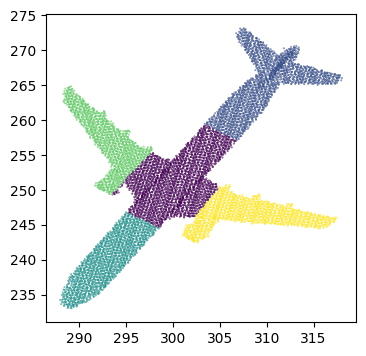

In [503]:
# 2D plot of image segmentation
plt.figure(figsize=(4,4))
plt.scatter(x[mask], y[mask], c=kmeans_aerpl.labels_, s = 0.1)
plt.show()

### 3D plot of the segmented point cloud

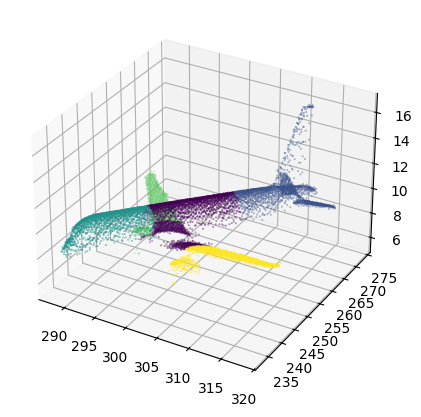

In [504]:
# 3D plot of image segmentation
plt.figure(figsize=(5,5))
ax = plt.axes(projection ='3d')
ax.scatter(x[mask], y[mask], z[mask], c=kmeans_aerpl.labels_, s=0.1)
plt.show()

### Calculate the Silhouette Score

In [505]:
print(f'Silhouette Score: {silhouette_score(X2, kmeans_aerpl.labels_):.4f}')

Silhouette Score: 0.4704


## 4.) Finding clusters in the apartment data
<a id='section_4'></a>

### Import the apartment data

In [506]:
# Define columns for import
columns = [ 'web-scraper-order',
            'address_raw',
            'rooms',
            'area',
            'luxurious',
            'price',
            'price_per_m2',
            'lat',
            'lon',
            'bfs_number',
            'bfs_name',
            'pop',
            'pop_dens',
            'frg_pct',
            'emp',
            'mean_taxable_income',
            'dist_supermarket']

# Read and select variables
df_orig = pd.read_csv("apartments_data_enriched_cleaned.csv", sep=";", encoding='utf-8')[columns]

# Rename variable 'web-scraper-order' to 'apmt_id'
df_orig = df_orig.rename(columns={'web-scraper-order': 'id'})

# Remove missing values
df = df_orig.dropna()
df.head(5)

# Remove duplicates
df = df.drop_duplicates()

# Remove some 'extreme' values
df = df.loc[(df['price'] >= 1000) & 
            (df['price'] <= 5000)]

print(df.shape)
df.head(5)

(722, 17)


,id,address_raw,rooms,area,luxurious,price,price_per_m2,lat,lon,bfs_number,bfs_name,pop,pop_dens,frg_pct,emp,mean_taxable_income,dist_supermarket
0,1693998201-1,"Neuhusstrasse 6, 8630 Rüti ZH, ZH",3.0,49,0,1441,29.41,47.252171,8.845797,118,Rüti (ZH),12286,1221.272366,24.841283,5053,65362.04268,645.652248
1,1693998233-172,"Widacherstrasse 5, 8630 Rüti ZH, ZH",3.0,111,0,2600,23.42,47.252087,8.854919,118,Rüti (ZH),12286,1221.272366,24.841283,5053,65362.04268,265.102153
2,1693998256-331,"Widenweg 14, 8630 Rüti ZH, ZH",3.0,58,0,1490,25.69,47.253670,8.853993,118,Rüti (ZH),12286,1221.272366,24.841283,5053,65362.04268,94.401821
3,1693998265-381,"Rain 1, 8630 Rüti ZH, ZH",4.0,118,0,3240,27.46,47.259834,8.851705,118,Rüti (ZH),12286,1221.272366,24.841283,5053,65362.04268,106.660970
4,1693998276-419,"Bachtelstrasse 24b, 8630 Rüti ZH, ZH",3.0,66,0,1450,21.97,47.266113,8.866872,118,Rüti (ZH),12286,1221.272366,24.841283,5053,65362.04268,974.844209


### Subset of the apartment data frame for k-means clustering

In [507]:
# Define a subset of the data frame for k-means clustering
X3 = df[['rooms',
         'area',
         'price_per_m2']]

### Elbow method showing the optimal k

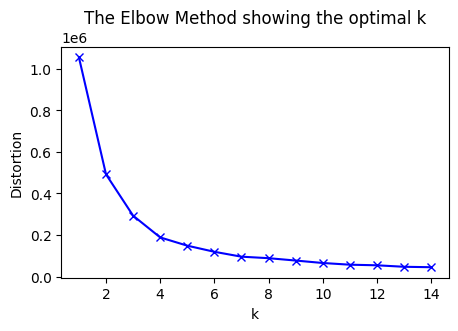

In [508]:
# Sum of squared distances of samples to their closest cluster center
distortions = []

# Range of k's
K = range(1,15)

# Loop to find the optimal k
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X3)
    distortions.append(kmeanModel.inertia_)
    
# Elbow plot
plt.figure(figsize=(5,3))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

plt.show()

### Perform k-means clustering on the apartment data

In [509]:
# Number of clusters
k = 5

# Perform k-means clustering
kmeans_apmts = KMeans(n_clusters=k, random_state=42).fit(X3)

# Add the clusters to data frame
X3['cluster'] = kmeans_apmts.predict(X3)

# Show number of apartments per cluster
X3['cluster'].value_counts().sort_values(ascending=False)

cluster
1    261
3    252
0    108
2     79
4     22
Name: count, dtype: int64

### Plot the apartment clusters

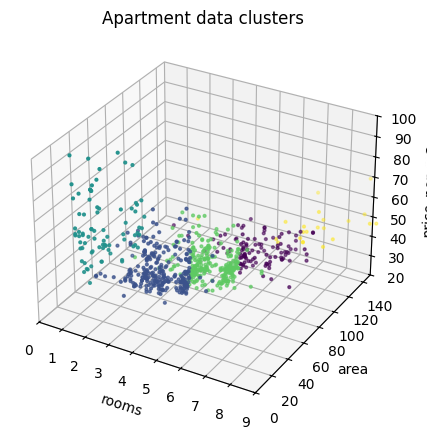

In [510]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['rooms'], df['area'], df['price_per_m2'], c=kmeans_apmts.labels_, s=4)

# Set title and axes labels
ax.set_title('Apartment data clusters', fontsize=12)
ax.set_xlabel('rooms', fontsize=10)
ax.set_ylabel('area', fontsize=10)
ax.set_zlabel('price_per_m2', fontsize=10)

# Set axes range
ax.set_xlim([0,9])
ax.set_ylim([0,150])
ax.set_zlim([20,100])

plt.show()

### Calculate the Silhouette Score

In [511]:
print(f'Silhouette Score: {silhouette_score(X3, kmeans_apmts.labels_):.4f}')

Silhouette Score: 0.4547


### Jupyter notebook --footer info-- (please always provide this at the end of each submitted notebook)

In [512]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Darwin | 24.0.0
Datetime: 2024-11-19 18:23:34
Python Version: 3.10.14
-----------------------------------
